### HENRIQUE GUIMARAES
### 10563
### 05/11/2024

# Introduction

The job shop scheduling problem (JSSP) is an optimization problem and a well-known Constraint Satisfaction Problem (CSP) in the field of Artificial Intelligence. It involves scheduling a set of jobs or tasks, that need to be processed on specific machines or resources within a given timeframe. The goal is to allocate the resources, being renewable or not, effectively to minimize the overall time required to complete all jobs (makespan) while adhering to various constraints such as resource availability, job precedence, successors and task durations. The complexity of JSSP makes it a challenging problem suitable for constraint programming techniques.



# Goal formulation

The primary goal of this project is to create an optimal job schedule that minimizes the makespan, defined as the total time taken to complete all jobs. This will be achieved by effectively utilizing the available resources while satisfying constraints related to job dependencies, resource capacities, and specific job priorities.


# Agent's Attributes

The scheduling system's primary goal is to minimize the makespan, which represents the total time required to complete all jobs. 
The system ensures that there is not overlapping of jobs on the same resource, mainting operational efficiency while also respecting the job precendence requirements and dependencies between tasks and making sure no resource is overutilized.

The scheduling process operates in a structured environment consisting of a defined set of jobs, each having specific durations and resource requirements and a finite number of resources.

The core action mechanism is the scheduling algorithm, which dynamically assigns the start and end times for each job, and the resources to jobs based on their availability and constraints.

This holistic design ensures an efficient, constraint-driven scheduling process tailored to the environment and performance objectives.

# Characteristics of the task environment

Dynamic because changes can occur in job priorities or durations
Partially observable because there is limited visibility into external factors affecting job scheduling, such as machine breakdowns or delays
Deterministic since it is given the same input, the schedule will always yield the same output if no external factors change
Jobs and resources are distinct entities  with specific start and finish times.

# Variables and Domains

Start time -> job_starts
End time -> job_ends
Interval -> job_intervals

### Domains

The domain of each variable is defined by the maximum possible duration which is 0 to max_duration * num_jobs

### Constraints

No overlapping on same resources
Resource capacity to limit the number of jobs tha can be processed simultaneosuly on a resource
Job prioritization where specific jobs must finish by certain deadlines
Job precedence where certain jobs must finish before the next starts
Minimize makespan: Minimizes the maximum completion time across all schedule

# IMPORT

In [55]:
from ortools.sat.python import cp_model
import pandas as pd
import matplotlib.pyplot as plt
import re
import time

# IMPLEMENTATION

The implementation of this task started from processing the dataset and parsing important lines such as the resources, durations of those resources, the precendence relations (successors) and resource availability. The next step involves the precendence constraints, sorting each task according to their successor.

In [56]:
job_data = []
precedence_constraints = {}
resource_capacities = {}

# Parse the file
with open("p01_dataset_8.txt", "r") as file:
    lines = file.readlines()

    parsing_durations = False
    parsing_precedence = False
    parsing_resources = False
    parsing_renewable = False

    lines_iter = iter(lines)
    for line in lines_iter:
        if line.startswith("RESOURCES"):
            parsing_renewable = True
            parsing_durations = False
        elif line.startswith("#Duration and resources"):
            parsing_durations = True
            parsing_precedence = False
            continue
        elif line.startswith("#Precedence relations"):
            parsing_precedence = True
            parsing_durations = False
            continue
        elif line.startswith("#Resource availability"):
            parsing_resources = True
            parsing_precedence = False
            continue

        if parsing_durations and not line.startswith("#"):
            parts = list(map(int, re.findall(r'\d+', line)))
            
            if len(parts) >= 5:
                job_id, duration, r1, r2 = parts[0], parts[2], parts[3], parts[4]
                job_data.append({'Job': job_id, 'Duration': duration, 'R1': r1, 'R2': r2})
            else:
                print(f"Skipping line due to insufficient data: {line}")

        # RENEWABLE RESOURCES

        # if parsing_renewable and not line.startswith("#"):
        #     parts = line.split(":")
        #     if len(parts) == 2:
        #         resource_info, capacity_info = parts
        #         resource = resource_info.strip().split()[1]
        #         capacity = int(capacity_info.strip().split()[0])  
        #         resource_capacities[resource] = capacity
        #     else:
        #         print(f"Skipping line due to insufficient data: {line}")

        if parsing_precedence and not line.startswith("#Precedence relations"):
            parts = list(map(int, re.findall(r'\d+', line)))
            if len(parts) >= 4:  
                job_id = parts[0]
                num_successors = parts[2] 
                successors = parts[3:3 + num_successors] 
                precedence_constraints[job_id] = successors

        if parsing_resources and not line.startswith("#"):
            parts = line.split()
            if len(parts) == 2:
                resource, capacity = parts
                resource_capacities[resource] = int(capacity)
            else:
                print(f"Skipping line due to insufficient data: {line}")


jobs_df = pd.DataFrame(job_data)

model = cp_model.CpModel()
resource_intervals = {'R1': [], 'R2': []}

job_starts = {}
job_ends = {}
job_intervals = {}
successor_interval = {}

num_jobs = len(jobs_df)
max_duration = sum(jobs_df['Duration']) 

for index, row in jobs_df.iterrows():
    job = row['Job']
    duration = row['Duration']
    
    start_var = model.NewIntVar(0, max_duration, f'start_{job}')
    end_var = model.NewIntVar(0, max_duration, f'end_{job}')
    interval_var = model.NewIntervalVar(start_var, duration, end_var, f'interval_{job}')
    
    job_starts[job] = start_var
    job_ends[job] = end_var
    job_intervals[job] = interval_var

    # print(f"Job {job} starts at {start_var} and ends at {end_var}")
    
printed_jobs = set()  # Initialize an empty set to track printed jobs

for job in sorted(precedence_constraints):
    if job not in printed_jobs:  # Check if the job has already been printed
        successors = precedence_constraints.get(job, [])
        if successors:
            print(f'Job {job} with successors {successors}')
        else:
            print(f'Job {job} has no successors')
        printed_jobs.add(job)  # Mark the job as printed



Skipping line due to insufficient data: ************************************************************************

Skipping line due to insufficient data:   R1        6   

Skipping line due to insufficient data:   R2        9 

Skipping line due to insufficient data: ************************************************************************
Skipping line due to insufficient data: ************************************************************************
Job 1 with successors [2, 3, 4]
Job 2 with successors [6, 9, 14]
Job 3 with successors [5, 8, 11]
Job 4 with successors [12, 16, 20]
Job 5 with successors [9, 17]
Job 6 with successors [7, 12, 18]
Job 7 with successors [8, 17]
Job 8 with successors [15, 16]
Job 9 with successors [10, 13, 16]
Job 10 with successors [12, 20]
Job 11 with successors [14, 15, 19]
Job 12 with successors [19, 21]
Job 13 with successors [15]
Job 14 with successors [18]
Job 15 with successors [21]
Job 16 with successors [21]
Job 17 with successors [19]
Job 18 with s

# CONSTRAINTS

In [57]:
# Non-overlapping constraints
for job_id_i in jobs_df['Job']:
    for job_id_j in jobs_df['Job']:
        if job_id_i < job_id_j:
            model.AddNoOverlap([job_intervals[job_id_i], job_intervals[job_id_j]])

# Precedence constraints
for job_id, successors in precedence_constraints.items():
    if job_id not in job_ends or job_id not in job_starts:
        continue

    for successor in successors:
        if successor not in job_ends or successor not in job_starts:
            continue 

        if job_id != successor:
            if job_id not in precedence_constraints.get(successor, []):
                model.Add(job_ends[job_id] <= job_starts[successor])
                # print(f"Job {job_id} must end before Job {successor} starts")

# Resource constraints
for resource, capacity in resource_capacities.items():
    resource_usage = []
    for job_id, row in jobs_df.iterrows():
        job = row['Job']
        resource_usage.append(job_intervals[job])
    
    model.AddCumulative(resource_usage, [row['R1'] if resource == 'R1' else row['R2'] for index, row in jobs_df.iterrows()], capacity)
    print(f"Resource {resource} has a capacity of {capacity}")

# Print assigned resources
# for job_id, row in jobs_df.iterrows():
#     job = row['Job']
#     print(f"Job {job} requires {row['R1']} of R1 and {row['R2']} of R2")





Resource R1 has a capacity of 6
Resource R2 has a capacity of 9


# DISPLAY SCHEDULE METHOD

In [58]:
def display_schedule(schedule):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title('Job Scheduling Gantt Chart')

    # Create the Gantt bars
    for job_id, start, end in schedule:
        plt.barh(f'Job {job_id}', end - start, left=start, color='skyblue', edgecolor='black')
        plt.text(start + (end - start) / 2, f'Job {job_id}', f'Job {job_id}', ha='center', va='center', color='black', fontsize=10) 

    plt.xlabel('Time')
    plt.ylabel('Jobs')

    plt.grid(True, axis='x')
    plt.show()


# SOLVE

Optimal Schedule:
Job 1 starts at 0, ends at 0
Job 2 starts at 6, ends at 8, using R2: 4
Job 3 starts at 0, ends at 1, using R2: 2
Job 4 starts at 16, ends at 20, using R1: 6
Job 5 starts at 1, ends at 6, using R2: 2
Job 6 starts at 15, ends at 16, using R2: 3
Job 7 starts at 25, ends at 31, using R2: 4
Job 8 starts at 38, ends at 40, using R1: 4
Job 9 starts at 8, ends at 15, using R2: 3
Job 10 starts at 31, ends at 33, using R2: 3
Job 11 starts at 20, ends at 25, using R2: 2
Job 12 starts at 33, ends at 38, using R1: 2
Job 13 starts at 61, ends at 63, using R1: 2
Job 14 starts at 40, ends at 48, using R2: 2
Job 15 starts at 63, ends at 66, using R2: 3
Job 16 starts at 53, ends at 61, using R2: 2
Job 17 starts at 48, ends at 53, using R1: 2
Job 18 starts at 76, ends at 84, using R2: 2
Job 19 starts at 66, ends at 76, using R2: 4
Job 21 starts at 84, ends at 91, using R1: 3
Job 22 starts at 92, ends at 92
--------------------------------------------------
Optimal makespan: 92
Displayin

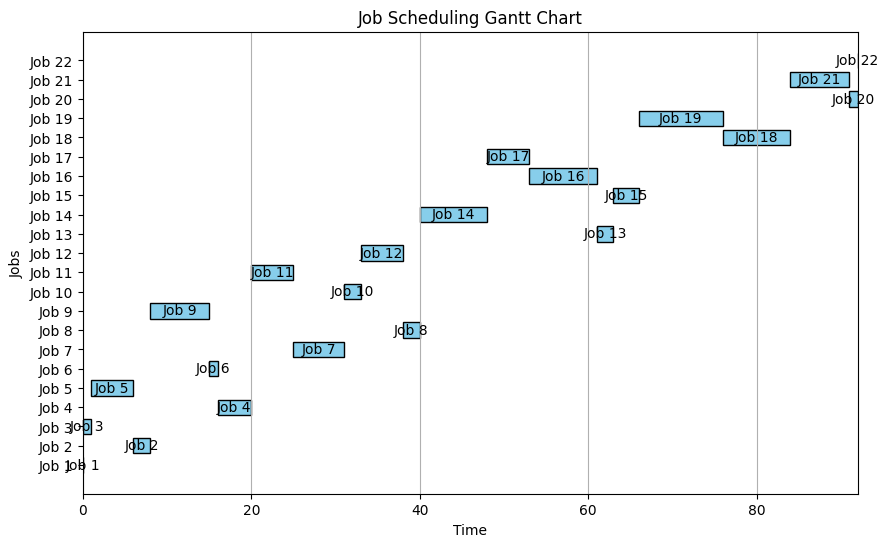

In [60]:

solver = cp_model.CpSolver()
status = solver.Solve(model)
schedule = []

if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print("Optimal Schedule:")
    schedule = []
    for job_id in job_starts.keys():
        start_value = solver.Value(job_starts[job_id])
        end_value = solver.Value(job_ends[job_id])
        schedule.append((job_id, start_value, end_value))
        resource_r1 = jobs_df.loc[jobs_df['Job'] == job_id, 'R1'].values[0]
        resource_r2 = jobs_df.loc[jobs_df['Job'] == job_id, 'R2'].values[0]

        if resource_r1 == 0 and resource_r2 == 0:
            print(f"Job {job_id} starts at {start_value}, ends at {end_value}")
        elif resource_r1 == 0:
            print(f"Job {job_id} starts at {start_value}, ends at {end_value}, using R2: {resource_r2}")
        elif resource_r2 == 0:
            print(f"Job {job_id} starts at {start_value}, ends at {end_value}, using R1: {resource_r1}")

    # Read console input to decide if we want to sort the schedule or not
    sort_schedule = input("Do you want to sort the schedule by start time? (y/n): ")

    makespan = max([solver.Value(job_ends[job_id]) for job_id in job_ends])
    print('-' * 50)
    print(f"Optimal makespan: {makespan}")

    if sort_schedule.lower() == 'y':
        schedule.sort(key=lambda x: x[1])
        display_schedule(schedule)
    else:
        print("Displaying schedule not sorted")
        display_schedule(schedule)

else:
    print("No feasible solution found")


